# Time Series Decomposition

The goal of this material is to introduce basic time series decomposition methods that can be applied to separate the various sub-patterns that are typically combined within time series data.  Many techniques can be used for this purpose and, as an introduction to this general topic, the computations contained herein are aimed, first, at communicating clearly what time series decompositon is and a general approach.

We have seen this image in class previously which nicely visualizes what we will be doing in the two examples included in this Jupyter notebook.

![Cleveland Time Series Decomposition](ClevelandTimeSeriesDecomposition.jpg)

## Demand Pattern Decomposition

This first example is obviously fictious data because its patterns appear to be significantly more consistent across time than  real-world data.  Nonetheless, it is a good first exercise, particualrly, because the easily observed patterns make this first exercise easier than is normally the case.

This data was adapted from the textbook _Supply Chain Management: 3rd Edition_, by Sunil Chopra and Pter Meindl,  Prentice Hall, 2006.

First, let's import all the packages we will need, as well as the magic command for plotting in the Jupyter notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('TSDataP1.csv')
df

,Quarter,Product1Demand
0,1,152400
1,2,185000
2,3,182880
3,4,161544
4,5,166116
5,6,202692
6,7,198120
7,8,176784
8,9,182880
9,10,216408


We will need a column for the Quarter index to use with computation, so let's create that now.  We will use a zero-based index. 

In [3]:
df['Quarter'] = df.index
df

,Quarter,Product1Demand
0,0,152400
1,1,185000
2,2,182880
3,3,161544
4,4,166116
5,5,202692
6,6,198120
7,7,176784
8,8,182880
9,9,216408


Let's look at the data, first, to begin to understand it.

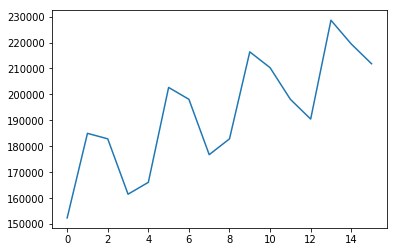

In [4]:
plt.plot(df.Quarter,df.Product1Demand)

Describe the pattern in this graph?  What "component patterns" do you see within the overall graph?

At this point you should observe an overall (positive) trend  and seasonality.  To perceive the trend, ask what results a linear regression analysis would yield for intercept adn slope.  Perhaps, you will intuit that the trend in this graph is a linear one rather than a nonlinear one.

You could, and should ask yourself what is causing those patterns.  You may know the causes from experience if you are familiar with the context or, alternately, you may need to do research to determine the causes.  If you were a consultant, you might well be in the latter position.

Our goal now is to decompose these data.  Doing so will enable us to forecast demand into the future because the components are easier to detect and express individually, so that we may exptrapolate them into the future.  We need to assume a functional form for how the components contribute to the overall pattern in order to guide the math that we do.  For our pruposes, we will assume this model, which is called an additive model:

- $D$ = Product Demand 
- $q$ = the index of the quarter
- $L$ = The 'level' component of the demand pattern which is a constant value
- $T$ = The (linear) trend of the data.  This is the amount that demand increases, on average, from one quarter to the next.  T is also a constant.
- $S \left(q \right)$ = Seasonality component.  We need to figure out how many quarters there are before the seaonal pattern repeats so that we can determine the seasonality component for each quarter, $q$.
- $\epsilon \left( q \right)$ is the portion of demand that we will not be able to fit with $L$, $T \left(q \right)$ and $S \left(q \right)$.


$D\left(q \right) = L + T q  + S \left(q \right) + \epsilon \left( q \right)$ 

We can easily get $L$and $T$ from a linear regression analysis.  We will use a new Python package for this analysis.  Many Python packages can do this analysis well.  

In [5]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df['Product1Demand'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 165969.76470588235     slope = 3567.764705882353      p_value =  0.0004266677252921289


Now we need to 'remove' the trend and the level from the original demand pattern to see what pattern remains for use to describe seasonality.  We use the DataFrame.apply() method from pandas for this task.

In [6]:
def create_regress_col(row, intercept, slope):
    return float(intercept) + float(row[0]) * slope
    
df['regress'] = df.apply(create_regress_col,args = (intercept,slope),axis = "columns")
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format
})

,Quarter,Product1Demand,regress
0,0,"152,400","165,970"
1,1,"185,000","169,538"
2,2,"182,880","173,105"
3,3,"161,544","176,673"
4,4,"166,116","180,241"
5,5,"202,692","183,809"
6,6,"198,120","187,376"
7,7,"176,784","190,944"
8,8,"182,880","194,512"
9,9,"216,408","198,080"


In the computation below, a column is created in the DataFrame whose name is 'R1'.  The 'R' stands for remainder of the original sales trajectory after the regression 'pattern' has been extracted from the original sales pattern.

In [7]:
df['R1'] = df['Product1Demand'] - df['regress']
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format
})

,Quarter,Product1Demand,regress,R1
0,0,"152,400","165,970","-13,570"
1,1,"185,000","169,538","15,462"
2,2,"182,880","173,105","9,775"
3,3,"161,544","176,673","-15,129"
4,4,"166,116","180,241","-14,125"
5,5,"202,692","183,809","18,883"
6,6,"198,120","187,376","10,744"
7,7,"176,784","190,944","-14,160"
8,8,"182,880","194,512","-11,632"
9,9,"216,408","198,080","18,328"


Here is a plot of the R1 data column.

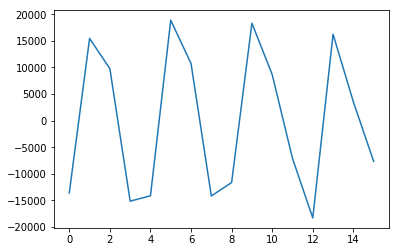

In [8]:
plt.plot(df.index,df.R1)

This looks like a repeated pattern.

How many quarters pass before the pattern repeats?

When the autocorrelation value for a particular lag is large (close to 1) and positive, it indicates a cyclic pattern with the periodicty of that lag.

In [9]:
for i in range(int(len(df.index)/2)):
    print('autocorrelation, lag =',i,':',df.R1.autocorr(lag = i))

autocorrelation, lag = 0 : 0.9999999999999999
autocorrelation, lag = 1 : -0.1102785302304146
autocorrelation, lag = 2 : -0.868909408472876
autocorrelation, lag = 3 : 0.02273671993213273
autocorrelation, lag = 4 : 0.9658506974344422
autocorrelation, lag = 5 : -0.08723019865257386
autocorrelation, lag = 6 : -0.8908995827540017
autocorrelation, lag = 7 : 0.006562427249447057


This code plots each sequential series of 4 points, where 4 corresponds with the periodicty of the data.  Note how the patterns have similar shapes, which is why the autocorrelation with this lag was nearly 1.  Let's create a graph that demonstrates this by plotting each successive group of four points.

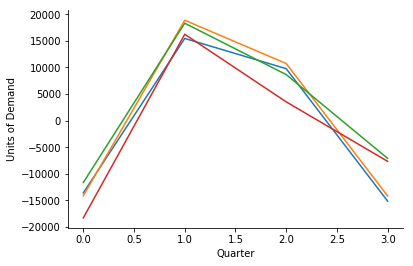

In [10]:
dfQtr = pd.DataFrame()
cycleLen = 4
for i in range(int(len(df.index)/cycleLen)):
    newData = pd.DataFrame({i:df['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfQtr = pd.concat([dfQtr,newData],axis=1)

fig,ax = plt.subplots()
ax.plot(dfQtr)
ax.set_xlabel('Quarter')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

If we average the demand for each of the seasonal quarters, so those averages represent all the curves well?

              0             1             2             3           avg
0 -13569.764706 -14124.823529 -11631.882353 -18282.941176 -14402.352941
1  15462.470588  18883.411765  18328.352941  16249.294118  17230.882353
2   9774.705882  10743.647059   8664.588235   3537.529412   8180.117647
3 -15129.058824 -14160.117647  -7095.176471  -7650.235294 -11008.647059


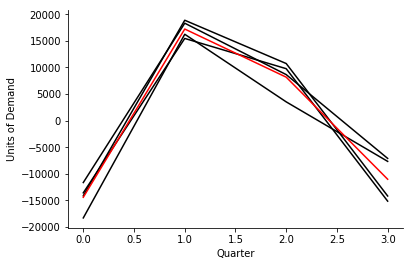

In [11]:
avg = []
for i in range(len(dfQtr.index)):
    avg.append(dfQtr.iloc[i].mean())

dfQtr = pd.concat([dfQtr,pd.DataFrame({'avg':avg})], axis=1)
print(dfQtr)

fig,ax = plt.subplots()
c = 180
for col in dfQtr.columns.values:
    if col == 'avg':
        ax.plot(dfQtr[col], c = 'r')
    else:
        ax.plot(dfQtr[col], c = 'k')
ax.set_xlabel('Quarter')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

What does the remainder of the demand pattern look like if we use the average seasonality?

In [12]:
#def calcR2(row):
#    return row[3] - row[4]
    
df['S'] = np.NaN
df['error'] = np.NaN
df['R2'] = np.NaN
df['Forecast'] = np.NaN
S = dfQtr['avg'].tolist()
for i in df.index:
    df.loc[i,'S'] = S[i%cycleLen]
    df.loc[i,'R2'] = df.loc[i,'R1'] - df.loc[i,'S']
    df.loc[i,'Forecast'] = df.loc[i,'regress'] + df.loc[i,'S']
    df.loc[i,'error'] = df.loc[i,'R2'] / df.loc[i,'Product1Demand']
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format,
    'S': '{:,.0f}'.format,
    'R2': '{:,.0f}'.format,
    'Forecast':'{:,.0f}'.format,
    'error': '{:.4f}'.format
})

,Quarter,Product1Demand,regress,R1,S,error,R2,Forecast
0,0,"152,400","165,970","-13,570","-14,402",0.0055,833,"151,567"
1,1,"185,000","169,538","15,462","17,231",-0.0096,"-1,768","186,768"
2,2,"182,880","173,105","9,775","8,180",0.0087,"1,595","181,285"
3,3,"161,544","176,673","-15,129","-11,009",-0.0255,"-4,120","165,664"
4,4,"166,116","180,241","-14,125","-14,402",0.0017,278,"165,838"
5,5,"202,692","183,809","18,883","17,231",0.0082,"1,653","201,039"
6,6,"198,120","187,376","10,744","8,180",0.0129,"2,564","195,556"
7,7,"176,784","190,944","-14,160","-11,009",-0.0178,"-3,151","179,935"
8,8,"182,880","194,512","-11,632","-14,402",0.0151,"2,770","180,110"
9,9,"216,408","198,080","18,328","17,231",0.0051,"1,097","215,311"


Let's visualize how our model of demand fits actual product demand

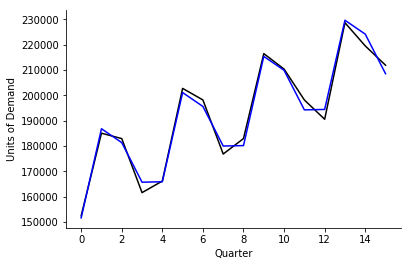

In [13]:
fig, ax = plt.subplots()
ax.plot(df['Product1Demand'],c='k')
ax.plot(df['Forecast'],c='b')
ax.set_xlabel('Quarter')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Here is a plot of the remainder, that is, the error of our model.

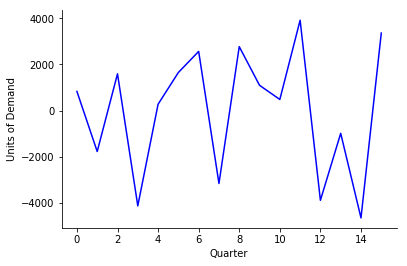

In [14]:
fig, ax = plt.subplots()
ax.plot(df.index,df.R2, c='b')
ax.set_xlabel('Quarter')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

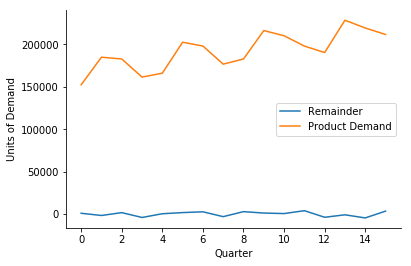

In [15]:
fig, ax = plt.subplots()
ax.plot(df.index,df.R2,label='Remainder')
ax.plot(df.index,df.Product1Demand,label = "Product Demand")
ax.set_xlabel('Quarter')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

Here is a package that does decomposition in one step.

## United States Monthly Home Sales Time Series Decomposition

This data was downloaded form teh Internet (link to be added) and it portrays monthly home sales in the United States on a monthly basis where the data have _not been seasonally adjusted_ as is the case with many data sources.

We will use a similar, but more general model for the Home Sales data.  Specifically, we will use this model:

$D\left(q \right) = T\left( q \right) + C\left( q \right) + \epsilon \left( q \right)$

where

- $D\left( q \right)$ = Product Demand in Quarter $q$
- $q$ = the index of the quarter
- $L$ = The 'level' component of the demand pattern which is a constant value
- $T\left( q \right)$ = $T$ represents the trend of the data which, in this case, could be nonlinear.  $T\left( q \right)$ is the trend value for Quarter $q$.
- $C\left( q \right)$ = Cyclicality demand component, which plays an analogous role to $S\left( q \right)$, except that the pattern repeats after some number of periods which might not be four quarters.
- $\epsilon \left( q \right)$ is the portion of demand that we will not be able to fit with $L$, $T \left(q \right)$ and $S \left(q \right)$.

Often, the ultimate goal of decomposing data like these is to forecast demand into the future because the components are easier to detect and express individually: Those components can be exptrapolated into the future and combined to create a forecast.  






In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The next cell of code computes the moving average of each point for a data window centered on each point.  The window size is a variable that can be easily changed, and the average squared error is computed in order to help evaluate which window size is appropriate for the moving average.

Average Squared Error per Month:  13110.987647849463
           YearMonth  homeSales    MovAvg          sqErr
2009-04-30   2009-04        536  657.5750   14780.480625
2009-05-31   2009-05        638  652.0625     197.753906
2009-06-30   2009-06        686  650.0625    1291.503906
2009-07-31   2009-07        896  648.8625   61076.943906
2009-08-31   2009-08        520  634.5750   13127.430625
2009-09-30   2009-09        734  617.2625   13627.643906
2009-10-31   2009-10        673  608.2000    4199.040000
2009-11-30   2009-11        760  598.7500   26001.562500
2009-12-31   2009-12        740  595.5000   20880.250000
2010-01-31   2010-01        471  593.8375   15089.051406
2010-02-28   2010-02        344  590.1375   60583.668906
2010-03-31   2010-03        527  580.8375    2898.476406
2010-04-30   2010-04        556  574.2750     333.975625
2010-05-31   2010-05        565  571.5125      42.412656
2010-06-30   2010-06        551  568.1750     294.980625
2010-07-31   2010-07        818  57

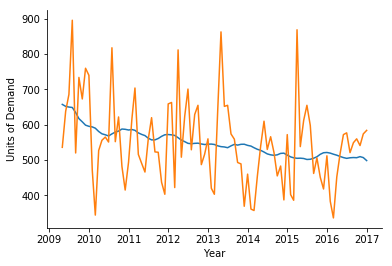

In [17]:
def sqErr(row):
    return (row[1] - row[2])**2
    
dates = ['2007-08','2007-09','2007-10','2007-11','2007-12','2008-01','2008-02','2008-03','2008-04','2008-05','2008-06','2008-07','2008-08','2008-09','2008-10','2008-11','2008-12','2009-01','2009-02','2009-03','2009-04','2009-05','2009-06','2009-07','2009-08','2009-09','2009-10','2009-11','2009-12','2010-01','2010-02','2010-03','2010-04','2010-05','2010-06','2010-07','2010-08','2010-09','2010-10','2010-11','2010-12','2011-01','2011-02','2011-03','2011-04','2011-05','2011-06','2011-07','2011-08','2011-09','2011-10','2011-11','2011-12','2012-01','2012-02','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09','2012-10','2012-11','2012-12','2013-01','2013-02','2013-03','2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12','2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08','2015-09','2015-10','2015-11','2015-12','2016-01','2016-02','2016-03','2016-04','2016-05','2016-06','2016-07','2016-08','2016-09','2016-10','2016-11','2016-12','2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08']
homeSales = [878,674,807,509,1641,701,1048,886,517,661,594,990,597,946,406,358,557,348,509,782,536,638,686,896,520,734,673,760,740,471,344,527,556,565,551,818,552,622,482,415,494,617,704,516,491,466,558,620,523,522,437,403,659,663,422,812,508,624,701,529,629,655,487,516,560,420,403,642,863,652,655,574,559,493,489,369,460,361,357,455,539,610,530,566,521,455,483,387,572,402,386,869,538,612,655,598,462,506,451,418,512,383,336,452,517,572,577,521,549,560,541,574,584,398,361,542,525,624,659,503,548,457,439,431,375,341,422,578,435,502,530,509,220]

dfHS = pd.DataFrame({'YearMonth':dates, 'homeSales':homeSales})
dfHS['MovAvg'] = np.NaN
dfHS['sqErr'] = np.NaN
# Chaging the DataFrame index to DatetimeIndex data type is required for using one of the functions below
dfHS.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2007, month=8, day=31), periods = len(dfHS['homeSales']))
#print(len(data),'\n',data)

window = 40
window = window - window % 2
for i in range(int(window/2),dfHS.shape[0]-int(window/2)):
    dfHS.loc[dfHS.index[i],'MovAvg'] = (0.5*dfHS.iloc[i - int(window/2)]['homeSales'] + dfHS.iloc[i - int(window/2)+1:i + int(window/2)]['homeSales'].sum() + 0.5*dfHS.iloc[i + int(window/2)]['homeSales'])/float(window)
dfHS['sqErr'] = dfHS.apply(sqErr,axis='columns')
# The moving average cannot be applied to all rows and we need to delete those rows because we cannot use them in the analysis
dfHS.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(dfHS['MovAvg'],label='Moving Avg.')
ax.plot(dfHS['homeSales'],label='Home Sales')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(dfHS['sqErr'])/len(dfHS))
print(dfHS)

The residual Home Sales yet to be explained, $R1$, is computed by subtracting the moving average from the demand time series.  Also, these are included in this code cell:
- Computing $R1$ as a percentage of demand ($R1Error$).
- The dfHS.style.format command demonstrates how to display pandas DataFrame data in whicever readble format you preer.

In [18]:
dfHS['R1'] = dfHS['homeSales'] - dfHS['MovAvg']
dfHS['R1Error'] = abs((dfHS['homeSales'] - dfHS['R1'])/dfHS['homeSales'])
dfHS.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,YearMonth,homeSales,MovAvg,sqErr,R1,R1Error
2009-04-30 00:00:00,2009-04,536,657.6,"14,780.5",-121.6,1.227
2009-05-31 00:00:00,2009-05,638,652.1,197.8,-14.1,1.022
2009-06-30 00:00:00,2009-06,686,650.1,"1,291.5",35.9,0.948
2009-07-31 00:00:00,2009-07,896,648.9,"61,076.9",247.1,0.724
2009-08-31 00:00:00,2009-08,520,634.6,"13,127.4",-114.6,1.220
2009-09-30 00:00:00,2009-09,734,617.3,"13,627.6",116.7,0.841
2009-10-31 00:00:00,2009-10,673,608.2,"4,199.0",64.8,0.904
2009-11-30 00:00:00,2009-11,760,598.8,"26,001.6",161.2,0.788
2009-12-31 00:00:00,2009-12,740,595.5,"20,880.2",144.5,0.805
2010-01-31 00:00:00,2010-01,471,593.8,"15,089.1",-122.8,1.261


The cell below helps us visualize the remaining pattern to be decomposed, $R1$, and it also computes the average resdiual demadn pattern.

Average Residual:  1.1362903225806436


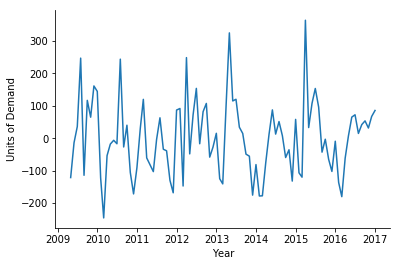

In [19]:
fig,ax = plt.subplots()
ax.plot(dfHS['R1'])
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(dfHS['R1'])/len(dfHS))

Just as seasonal demand had a higher autocorrelation when the data were offet by four periods, we need to use autocorrelation analysis to detect whether any cyclical patterns exist and how many periods before they are repeated.

In [20]:
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfHS['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.22481472505501365
Correlation, lag  2     0.08812905308087504
Correlation, lag  3     0.04178196029892705
Correlation, lag  4     -0.1748971148922155
Correlation, lag  5     -0.15764053292559257
Correlation, lag  6     -0.12596441641442568
Correlation, lag  7     -0.22904312587558273
Correlation, lag  8     -0.1656663808668335
Correlation, lag  9     -0.029176224050737182
Correlation, lag  10     0.014552850474371569
Correlation, lag  11     0.01524251140179324
Correlation, lag  12     0.1987320050569167
Correlation, lag  13     0.08440857867279145
Correlation, lag  14     0.03825414044531637
Correlation, lag  15     0.03544656878424576
Correlation, lag  16     -0.18181922069029804
Correlation, lag  17     -0.24772248189327378
Correlation, lag  18     -0.18953736914002559
Correlation, lag  19     -0.16402781593880186
Correlation, lag  20     -0.0021322777822891693
Correlation, lag  21     0.05230061971462413
Correlation, lag  22     -0.09309490269834582
Correl

The code cell below breaks the time series into three components corresondign with each of the three cycles in the data.  note that the third cycle is partial.

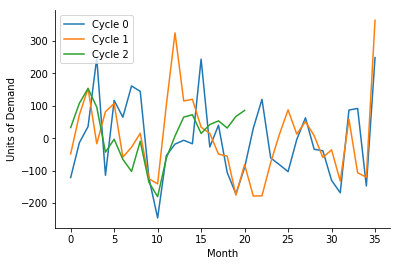

In [21]:
cycleLen = period
numCycles = int(len(dfHS)/cycleLen + 0.5)
cycles = [dfHS.iloc[range(i*period,min((i+1)*period,len(dfHS)))]['R1'] for i in range(numCycles)]
fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i))
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

This code cell:
- Computes the average home sales for each of the periods in the cycle.  that is, it computes $C\left( q \right)$
- Inserts the appropriate $C\left( q \right)$ value into the $C$ column in teh DataFrame for each Quarter $q$.
- Finally, a plot of the cyclicality component $C\left( q \right)$ is plotted with the $R1$ column to see how well the cyclicality component and it match.

Another view of the cyclical component we've approximated versus each of the three cycles.

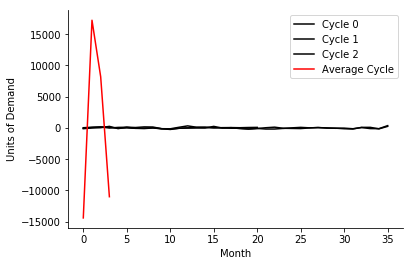

In [22]:
fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

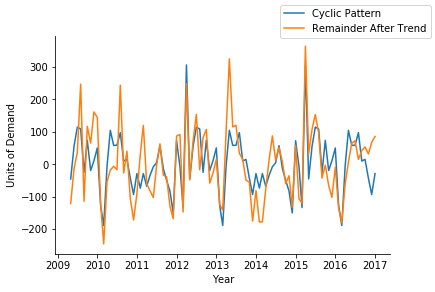

In [23]:
cycleLen = period   # see prior cell for computation of cyclicality period
avg = []            # a list to store the average demand for each period of the cycle
numCycles = int(len(dfHS)/cycleLen + 0.5)
for j in range(cycleLen):
    if j + (numCycles-1) * cycleLen < len(dfHS):
        d = dfHS.iloc[range(j,j + (numCycles-1) * cycleLen+1,cycleLen)]['R1']
        #print(j,d)
        avg.append(sum(d)/len(d))
    else:
        d = dfHS.iloc[range(j,j + (numCycles-2) * cycleLen+1,cycleLen)]['R1']
        #print(j,d)
        avg.append(sum(d)/len(d))
dfHS['C'] = np.NaN
for i in range(len(dfHS)):
    dfHS.loc[dfHS.index[i], 'C'] = avg[i % cycleLen]

fig,ax = plt.subplots()
ax.plot(dfHS['C'],label='Cyclic Pattern')
ax.plot(dfHS['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The code cell below does these:

- Computes the remaining residual home sales to be explained, $R2$, after subtracting the cyclical component, $C \left( q \right)$. 
- Computes the remainder after cyclicality, $R2$ as a percentage of the demand time series.
- Computes the mathematical model 'fit', composed of the trend and cyclical components: $T\left( q \right) + C\left( q \right)$.
- Plots the fit of the model $T\left( q \right) + C\left( q \right)$ with the original data, $D \left( q \right)$.
- Computes the average absolute error of $R2Error$ of the original demand time series.

           YearMonth  homeSales    MovAvg          sqErr        R1   R1Error  \
2009-04-30   2009-04        536  657.5750   14780.480625 -121.5750  1.226819   
2009-05-31   2009-05        638  652.0625     197.753906  -14.0625  1.022042   
2009-06-30   2009-06        686  650.0625    1291.503906   35.9375  0.947613   
2009-07-31   2009-07        896  648.8625   61076.943906  247.1375  0.724177   
2009-08-31   2009-08        520  634.5750   13127.430625 -114.5750  1.220337   
2009-09-30   2009-09        734  617.2625   13627.643906  116.7375  0.840957   
2009-10-31   2009-10        673  608.2000    4199.040000   64.8000  0.903715   
2009-11-30   2009-11        760  598.7500   26001.562500  161.2500  0.787829   
2009-12-31   2009-12        740  595.5000   20880.250000  144.5000  0.804730   
2010-01-31   2010-01        471  593.8375   15089.051406 -122.8375  1.260801   
2010-02-28   2010-02        344  590.1375   60583.668906 -246.1375  1.715516   
2010-03-31   2010-03        527  580.837

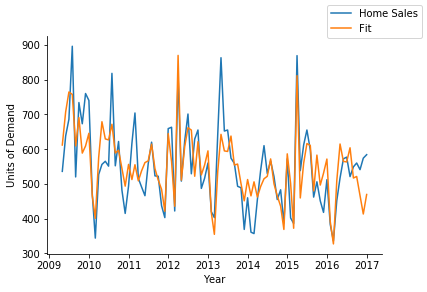

In [24]:
dfHS['R2'] = dfHS['R1'] - dfHS['C']
dfHS['R2Error'] = abs(dfHS['R2']/dfHS['homeSales'])
dfHS['fit'] = dfHS['MovAvg'] + dfHS['C']
print(dfHS)
fig,ax = plt.subplots()
ax.plot(dfHS['homeSales'],label='Home Sales')
ax.plot(dfHS['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Error: ', sum(dfHS['R2Error'])/len(dfHS))

Here is a plot of the residual $R2$ for visualization purposes to observe any remaining patterns that we might want to capture, and also an autocorrelation analysis of the residual.

Correlation, lag  1     0.3407551921909781
Correlation, lag  2     0.13100301233823802
Correlation, lag  3     -0.1766559507914226
Correlation, lag  4     -0.1003590415909726
Correlation, lag  5     -0.16814690922501
Correlation, lag  6     -0.12415781580954244
Correlation, lag  7     -0.05822002914434892
Correlation, lag  8     -0.13054080263986692
Correlation, lag  9     -0.23781484496066232
Correlation, lag  10     -0.1222172789940625
Correlation, lag  11     -0.08231661390561465
Correlation, lag  12     0.06261644536400905
Correlation, lag  13     -0.13766331183104474
Correlation, lag  14     0.10809732254492026
Correlation, lag  15     0.011247451157934421
Correlation, lag  16     0.04436394548925096
Correlation, lag  17     -0.14415108233385596
Correlation, lag  18     0.052789137547610075
Correlation, lag  19     0.15053368772446965
Correlation, lag  20     -0.0466652928229702
Correlation, lag  21     -0.09679940427971702
Correlation, lag  22     -0.1701938623693834
Correlation,

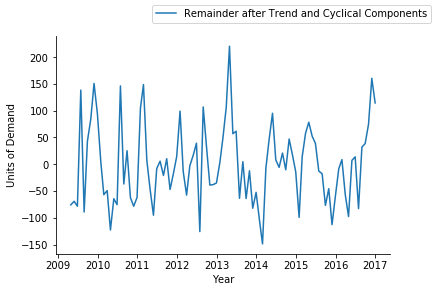

In [25]:
fig,ax = plt.subplots()
ax.plot(dfHS['R2'],label='Remainder after Trend and Cyclical Components')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfHS['R2'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

A final graph to show the model versus the original data and, as well, the remander $R2$ to judge it relative to the original demand we were trying to fit.

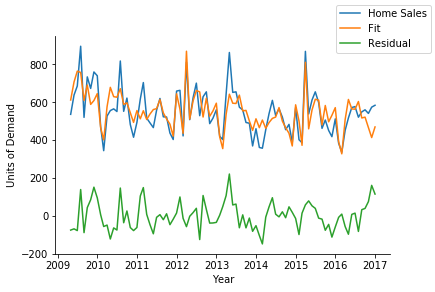

In [26]:
fig,ax = plt.subplots()
ax.plot(dfHS['homeSales'],label='Home Sales')
ax.plot(dfHS['fit'],label='Fit')
ax.plot(dfHS['R2'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Here is a package that performs time series decomposition in one statement, although you need to do some digging into the results for figure out how the model was constructed.  This is the computation that requires the pandas DataFrame index to be of the DatetimeIndex data type.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


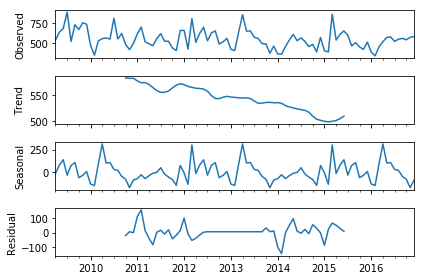

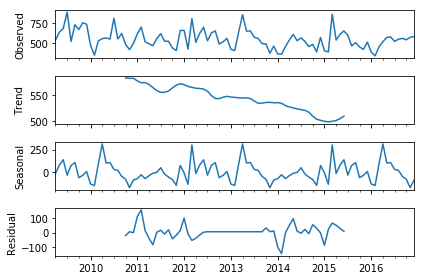

In [27]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(dfHS['homeSales'],freq=36)
res.plot()

## Another Approach to Monthly Home Sales Time Series Decomposition

The prior approach to decomposing monthly home sales works well, but it is not amenable to a forecast of future sales for the reasons we will discuss in class.  The approach used in this section differs only by how the trend cmoponent is computed, whcih is a moving average of some number of periods prior to the perio od sales we are trying to forecast.  That is, for each point it uses only data from the past relative to that point.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Average Squared Error per Month:  14189.294793028315
           YearMonth  homeSales      MovAvg         sqErr
2010-03-31   2010-03        527  713.566667  34807.121111
2010-04-30   2010-04        556  701.866667  21277.084444
2010-05-31   2010-05        565  697.933333  17671.271111
2010-06-30   2010-06        551  689.866667  19283.951111
2010-07-31   2010-07        818  691.266667  16061.337778
2010-08-31   2010-08        552  663.833333  12506.694444
2010-09-30   2010-09        622  658.866667   1359.151111
2010-10-31   2010-10        482  644.666667  26460.444444
2010-11-30   2010-11        415  631.200000  46742.440000
2010-12-31   2010-12        494  627.800000  17902.440000
2011-01-31   2011-01        617  622.233333     27.387778
2011-02-28   2011-02        704  623.000000   6561.000000
2011-03-31   2011-03        516  613.466667   9499.751111
2011-04-30   2011-04        491  610.766667  14344.054444
2011-05-31   2011-05        466  595.600000  16796.160000
2011-06-30   2011-0

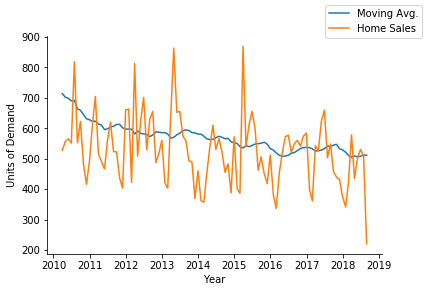

In [29]:
def sqErr(row):
    return (row[1] - row[2])**2
    
dates = ['2007-08','2007-09','2007-10','2007-11','2007-12','2008-01','2008-02','2008-03','2008-04','2008-05','2008-06','2008-07','2008-08','2008-09','2008-10','2008-11','2008-12','2009-01','2009-02','2009-03','2009-04','2009-05','2009-06','2009-07','2009-08','2009-09','2009-10','2009-11','2009-12','2010-01','2010-02','2010-03','2010-04','2010-05','2010-06','2010-07','2010-08','2010-09','2010-10','2010-11','2010-12','2011-01','2011-02','2011-03','2011-04','2011-05','2011-06','2011-07','2011-08','2011-09','2011-10','2011-11','2011-12','2012-01','2012-02','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09','2012-10','2012-11','2012-12','2013-01','2013-02','2013-03','2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12','2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08','2015-09','2015-10','2015-11','2015-12','2016-01','2016-02','2016-03','2016-04','2016-05','2016-06','2016-07','2016-08','2016-09','2016-10','2016-11','2016-12','2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08']
homeSales = [878,674,807,509,1641,701,1048,886,517,661,594,990,597,946,406,358,557,348,509,782,536,638,686,896,520,734,673,760,740,471,344,527,556,565,551,818,552,622,482,415,494,617,704,516,491,466,558,620,523,522,437,403,659,663,422,812,508,624,701,529,629,655,487,516,560,420,403,642,863,652,655,574,559,493,489,369,460,361,357,455,539,610,530,566,521,455,483,387,572,402,386,869,538,612,655,598,462,506,451,418,512,383,336,452,517,572,577,521,549,560,541,574,584,398,361,542,525,624,659,503,548,457,439,431,375,341,422,578,435,502,530,509,220]

dfHSa = pd.DataFrame({'YearMonth':dates, 'homeSales':homeSales})
dfHSa['MovAvg'] = np.NaN
dfHSa['sqErr'] = np.NaN
dfHSa.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2007, month=8, day=31), periods = len(dfHSa['homeSales']))
#print(len(data),'\n',data)

window = 30
for i in range(window+1,len(dfHSa)):
    dfHSa.loc[dfHSa.index[i],'MovAvg'] = sum(dfHSa.iloc[range(i-window-1,i)]['homeSales'])/float(window)
dfHSa['sqErr'] = dfHSa.apply(sqErr,axis='columns')
#print(data.head())
dfHSa.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(dfHSa['MovAvg'], label='Moving Avg.')
ax.plot(dfHSa['homeSales'], label='Home Sales')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Squared Error per Month: ',sum(dfHSa['sqErr'])/len(dfHSa))
print(dfHSa)

In [30]:
dfHSa['R1'] = dfHSa['homeSales'] - dfHSa['MovAvg']
dfHSa['R1Error'] = abs((dfHSa['homeSales'] - dfHSa['R1'])/dfHSa['homeSales'])
dfHSa.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format    
})

,YearMonth,homeSales,MovAvg,sqErr,R1,R1Error
2010-03-31 00:00:00,2010-03,527,713.6,"34,807.1",-186.567,1.35402
2010-04-30 00:00:00,2010-04,556,701.9,"21,277.1",-145.867,1.26235
2010-05-31 00:00:00,2010-05,565,697.9,"17,671.3",-132.933,1.23528
2010-06-30 00:00:00,2010-06,551,689.9,"19,284.0",-138.867,1.25203
2010-07-31 00:00:00,2010-07,818,691.3,"16,061.3",126.733,0.845069
2010-08-31 00:00:00,2010-08,552,663.8,"12,506.7",-111.833,1.2026
2010-09-30 00:00:00,2010-09,622,658.9,"1,359.2",-36.8667,1.05927
2010-10-31 00:00:00,2010-10,482,644.7,"26,460.4",-162.667,1.33748
2010-11-30 00:00:00,2010-11,415,631.2,"46,742.4",-216.2,1.52096
2010-12-31 00:00:00,2010-12,494,627.8,"17,902.4",-133.8,1.27085


Average Residual:  -44.28039215686276
Correlation, lag  1     0.26139365427306627
Correlation, lag  2     0.10498657768111407
Correlation, lag  3     0.10383505938041838
Correlation, lag  4     -0.1886295905008609
Correlation, lag  5     -0.14519435719226084
Correlation, lag  6     -0.0719196497635646
Correlation, lag  7     -0.1331146828176694
Correlation, lag  8     -0.13965228952253989
Correlation, lag  9     -0.041513821399192796
Correlation, lag  10     0.0026520514131592745
Correlation, lag  11     0.1643211127713046
Correlation, lag  12     0.29837285028569405
Correlation, lag  13     0.14368470699130775
Correlation, lag  14     -0.04303196541345698
Correlation, lag  15     -0.005491261700334031
Correlation, lag  16     -0.19846240061786916
Correlation, lag  17     -0.2132262843903361
Correlation, lag  18     -0.15721957959586197
Correlation, lag  19     -0.24932043294734885
Correlation, lag  20     -0.12181618792962301
Correlation, lag  21     -0.05554911240476115
Correlation, 

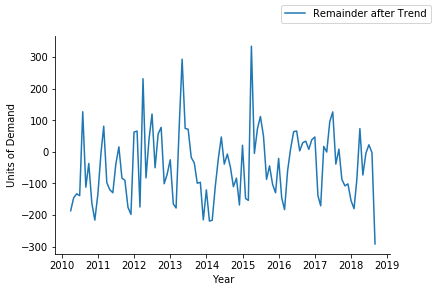

In [31]:
fig,ax = plt.subplots()
ax.plot(dfHSa['R1'],label='Remainder after Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Residual: ', sum(dfHSa['R1'])/len(dfHSa))

maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfHSa['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

0 2010-03-31   -186.566667
2013-03-31     75.000000
2016-03-31    -59.133333
Freq: 36M, Name: R1, dtype: float64
1 2010-04-30   -145.866667
2013-04-30    293.000000
2016-04-30      9.433333
Freq: 36M, Name: R1, dtype: float64
2 2010-05-31   -132.933333
2013-05-31     73.966667
2016-05-31     63.633333
Freq: 36M, Name: R1, dtype: float64
3 2010-06-30   -138.866667
2013-06-30     71.300000
2016-06-30     65.866667
Freq: 36M, Name: R1, dtype: float64
4 2010-07-31    126.733333
2013-07-31    -17.700000
2016-07-31      2.933333
Freq: 36M, Name: R1, dtype: float64
5 2010-08-31   -111.833333
2013-08-31    -35.366667
2016-08-31     28.900000
Freq: 36M, Name: R1, dtype: float64
6 2010-09-30   -36.866667
2013-09-30   -99.433333
2016-09-30    33.633333
Freq: 36M, Name: R1, dtype: float64
7 2010-10-31   -162.666667
2013-10-31    -96.400000
2016-10-31      7.866667
Freq: 36M, Name: R1, dtype: float64
8 2010-11-30   -216.2
2013-11-30   -215.5
2016-11-30     38.0
Freq: 36M, Name: R1, dtype: float64
9

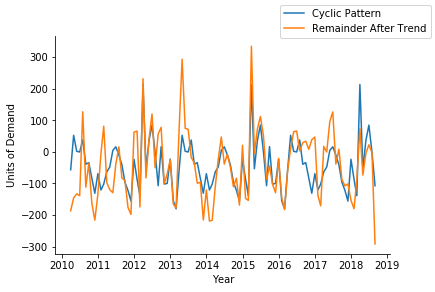

In [32]:
cycleLen = period   # see prior cell for computation of cyclicality period
avg = []            # a list to store the average demand for each period of the cycle
numCycles = int(len(dfHSa)/cycleLen + 0.5)
for j in range(cycleLen):
    if j + (numCycles-1) * cycleLen < len(dfHSa):
        d = dfHSa.iloc[range(j,j + (numCycles-1) * cycleLen+1,cycleLen)]['R1']
        print(j,d)
        avg.append(sum(d)/len(d))
    else:
        d = dfHSa.iloc[range(j,j + (numCycles-2) * cycleLen+1,cycleLen)]['R1']
        print(j,d)
        avg.append(sum(d)/len(d))
dfHSa['C'] = np.NaN
for i in range(len(dfHSa)):
    dfHSa.loc[dfHSa.index[i], 'C'] = avg[i % cycleLen]

fig,ax = plt.subplots()
ax.plot(dfHSa['C'],label='Cyclic Pattern')
ax.plot(dfHSa['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()


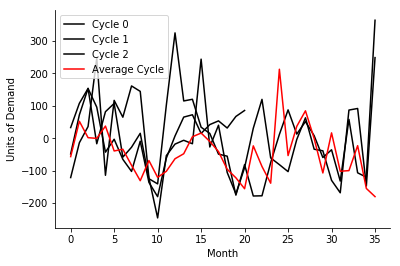

In [33]:
fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

           YearMonth  homeSales      MovAvg         sqErr          R1  \
2010-03-31   2010-03        527  713.566667  34807.121111 -186.566667   
2010-04-30   2010-04        556  701.866667  21277.084444 -145.866667   
2010-05-31   2010-05        565  697.933333  17671.271111 -132.933333   
2010-06-30   2010-06        551  689.866667  19283.951111 -138.866667   
2010-07-31   2010-07        818  691.266667  16061.337778  126.733333   
2010-08-31   2010-08        552  663.833333  12506.694444 -111.833333   
2010-09-30   2010-09        622  658.866667   1359.151111  -36.866667   
2010-10-31   2010-10        482  644.666667  26460.444444 -162.666667   
2010-11-30   2010-11        415  631.200000  46742.440000 -216.200000   
2010-12-31   2010-12        494  627.800000  17902.440000 -133.800000   
2011-01-31   2011-01        617  622.233333     27.387778   -5.233333   
2011-02-28   2011-02        704  623.000000   6561.000000   81.000000   
2011-03-31   2011-03        516  613.466667   9499.

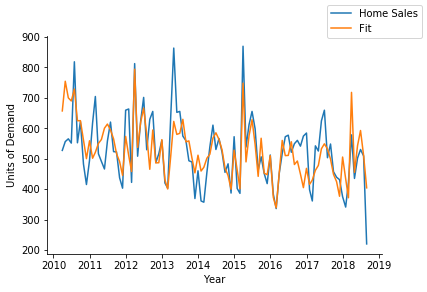

In [34]:
dfHSa['R2'] = dfHSa['R1'] - dfHSa['C']
dfHSa['R2Error'] = abs(dfHSa['R2']/dfHSa['homeSales'])
dfHSa['fit'] = dfHSa['MovAvg'] + dfHSa['C']
print(dfHSa)
fig,ax = plt.subplots()
ax.plot(dfHSa['homeSales'],label='Home Sales')
ax.plot(dfHSa['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Error: ', sum(dfHSa['R2Error']/len(dfHSa)))

Correlation, lag  1     0.36607601860455935
Correlation, lag  2     0.17717824059909718
Correlation, lag  3     0.05037594155915101
Correlation, lag  4     -0.03648114434725538
Correlation, lag  5     0.2193671767029301
Correlation, lag  6     0.12692528839724143
Correlation, lag  7     0.1508835980953447
Correlation, lag  8     0.0006065685997792922
Correlation, lag  9     -0.24362653546738522
Correlation, lag  10     -0.12024754148718543
Correlation, lag  11     0.05832273952647387
Correlation, lag  12     0.031088893201996426
Correlation, lag  13     -0.0720041886385924
Correlation, lag  14     -0.08212714387882643
Correlation, lag  15     -0.10420014558363878
Correlation, lag  16     -0.11210021206783544
Correlation, lag  17     -0.09169419951422685
Correlation, lag  18     -0.00996821665443028
Correlation, lag  19     -0.0933838301493063
Correlation, lag  20     -0.0913876975316234
Correlation, lag  21     -0.20885811421643155
Correlation, lag  22     -0.23445066360510794
Correlat

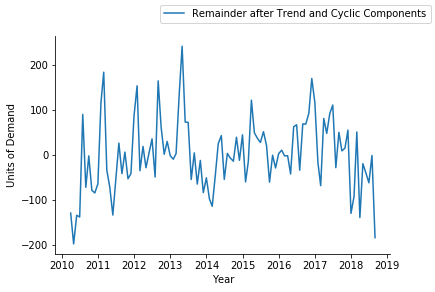

In [35]:
fig,ax = plt.subplots()
ax.plot(dfHSa['R2'], label='Remainder after Trend and Cyclic Components')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfHSa['R2'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

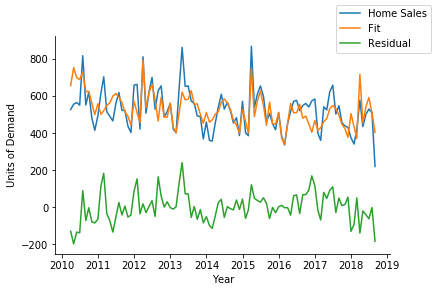

In [36]:
fig,ax = plt.subplots()
ax.plot(dfHSa['homeSales'],label='Home Sales')
ax.plot(dfHSa['fit'],label='Fit')
ax.plot(dfHSa['R2'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()